In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import missingno as msno

In [2]:
bike_df = pd.read_csv('./bike_sharing_demand/train.csv')

In [3]:
bike_df.shape

(10886, 12)

In [4]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [6]:
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)

bike_df['year'] = bike_df['datetime'].apply(lambda x : x.year)
bike_df['month'] = bike_df['datetime'].apply(lambda x : x.month)
bike_df['day'] = bike_df['datetime'].apply(lambda x : x.day)
bike_df['hour'] = bike_df['datetime'].apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [7]:
bike_df['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

In [8]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [10]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

로그로 변환한 값을 y, pred에 넣으면 rmsle가 되는 것 아닌가?

In [21]:
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

In [12]:
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mse_val = mean_absolute_error(y, pred)
    print('RMSLE:{:.3f}, RMSE:{:.3f}, MSE:{:.3f}'.format(rmsle_val, rmse_val, mse_val))

예측

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [22]:
X_features = bike_df.drop('count', axis=1, inplace=False)
y_target = bike_df['count']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
lr_reg_pred = lr_reg.predict(X_test)

evaluate_regr(y_test, lr_reg_pred)

RMSLE:1.165, RMSE:140.900, MSE:105.924


In [25]:
y_target.mean()

191.57413191254824

타겟값의 평균이 191인데 rmse가 140이면 평균만큼 차이가 나는 것이므로 엄청나게 차이가 많이나는 것이다.

DataFrame이 아니고 Series로 하면 컬럼 네임을 입력할 수 없기 때문에 안되는 건가?

In [33]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    print(result_df.sort_values('diff', ascending=False)[:n_tops])

In [34]:
get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


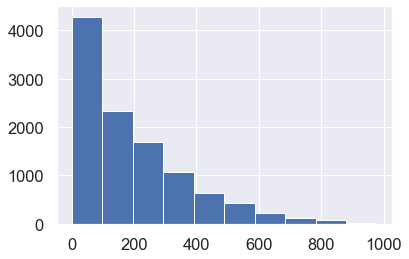

In [37]:
y_target.hist()

In [38]:
y_log_transform = np.log1p(y_target)

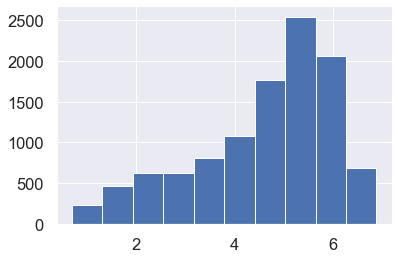

In [40]:
y_log_transform.hist()

In [41]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE:1.017, RMSE:162.594, MSE:109.286


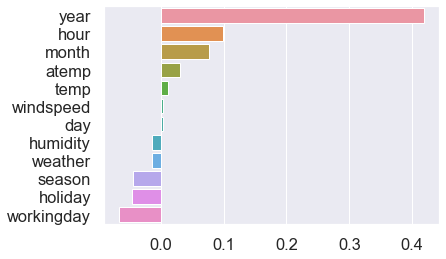

In [43]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [45]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'hour',
                                                    'holiday', 'workingday', 'season', 'weather'])

In [47]:
X_features_ohe.head()

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

In [50]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

In [51]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE:0.589, RMSE:97.485, MSE:63.107
### Ridge ###
RMSLE:0.589, RMSE:98.407, MSE:63.648
### Lasso ###
RMSLE:0.634, RMSE:113.031, MSE:72.658


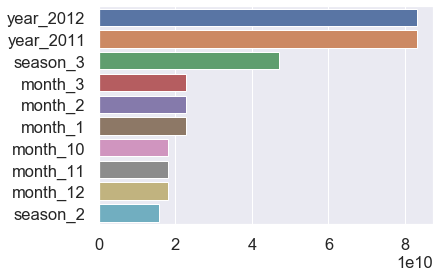

In [53]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [54]:
X_features_ohe.head()

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0


In [56]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [62]:
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(objective ='reg:squarederror', n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

In [63]:
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
RMSLE:0.354, RMSE:50.920, MSE:31.599
### GradientBoostingRegressor ###
RMSLE:0.341, RMSE:55.797, MSE:34.351


C:\Users\sejin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### XGBRegressor ###
RMSLE:0.346, RMSE:56.474, MSE:34.917
### LGBMRegressor ###
RMSLE:0.316, RMSE:46.473, MSE:28.777
